In [167]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import kendalltau, spearmanr, chi2_contingency, ttest_ind, bartlett, kruskal, mannwhitneyu,f_oneway
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from pandas.plotting import scatter_matrix
from sklearn.decomposition import FactorAnalysis as FA
from sklearn.decomposition import PCA
from sklearn import metrics
#!pip install fanalysis
#!pip install --user mca
#from mca import MCA as mca
#from fanalysis.mca import MCA as f_mca
#from fanalysis.ca import CA
!pip install prince
from prince import CA, MCA, FAMD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 5
import sqlite3

# Partie Machine Learning

## Construction du véhiculier pour identifier les véhicules à risques
* Utilisation de la base totale (ass) : assurés sinistré et assurés non sinistrés.

In [168]:
ass = pd.read_csv('ass.csv')

In [169]:
# Création de la variable sinnistre
ass["sinistre"] = (ass["claim_amount"] > 0).astype(int)

In [170]:
#Création des classes de cylindrée
ass["cyl_class"] = pd.cut(
    ass["vh_cyl"],
    bins=[0, 1200, 1600, 2000, np.inf],
    labels=["petite", "moyenne", "standard", "puissante"]
)

In [171]:
# Création des classes de vitesse
ass["speed_class"] = pd.cut(
    ass["vh_speed"],
    bins=[0, 140, 180, 220, np.inf],
    labels=["modérée", "élevée", "rapide", "très rapide"]
)

In [172]:
# Création du véhiculier (agrégation par type de carburant, cylindre et vitesse)
# Ajout de variables supplémentaires dans l'agrégation : vh_weight et pol_usage
vehiculier_extended = ass.groupby([
    "vh_type", "vh_fuel", "cyl_class", "speed_class", "pol_usage"
]).agg(
    nb_assures=("sinistre", "count"),
    freq_sinistre=("sinistre", "mean"),
    charge_moyenne=("claim_amount", "mean"),
    valeur_moyenne=("vh_value", "mean"),
    poids_moyen=("vh_weight", "mean"),
    age_moyen=("vh_age", "mean")
).reset_index()

C:\Users\cleme\AppData\Local\Temp\ipykernel_18972\282022699.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vehiculier_extended = ass.groupby([


In [173]:
vehiculier_extended.head()

,vh_type,vh_fuel,cyl_class,speed_class,pol_usage,nb_assures,freq_sinistre,charge_moyenne,valeur_moyenne,poids_moyen,age_moyen
0,Commercial,Diesel,petite,modérée,AllTrips,0,NaN,NaN,NaN,NaN,NaN
1,Commercial,Diesel,petite,modérée,Professional,0,NaN,NaN,NaN,NaN,NaN
2,Commercial,Diesel,petite,modérée,Retired,0,NaN,NaN,NaN,NaN,NaN
3,Commercial,Diesel,petite,modérée,WorkPrivate,0,NaN,NaN,NaN,NaN,NaN
4,Commercial,Diesel,petite,élevée,AllTrips,0,NaN,NaN,NaN,NaN,NaN


In [174]:
# Filtrer les lignes avec au moins un assuré
vehiculier_filtre = vehiculier_extended[vehiculier_extended["nb_assures"] > 0].copy()

# Réinitialiser les index
vehiculier_filtre.reset_index(drop=True, inplace=True)

In [175]:
# Ajout d'un indicateur de risque global
vehiculier_filtre["risque_total"] = vehiculier_filtre["freq_sinistre"] * vehiculier_filtre["charge_moyenne"]

In [176]:
print(vehiculier_filtre)

        vh_type   vh_fuel  cyl_class  speed_class     pol_usage  nb_assures  \
0    Commercial    Diesel     petite       élevée       Retired           1   
1    Commercial    Diesel     petite       élevée   WorkPrivate           1   
2    Commercial    Diesel    moyenne      modérée  Professional          42   
3    Commercial    Diesel    moyenne      modérée       Retired         118   
4    Commercial    Diesel    moyenne      modérée   WorkPrivate         176   
..          ...       ...        ...          ...           ...         ...   
155     Tourism  Gasoline  puissante       rapide       Retired         142   
156     Tourism  Gasoline  puissante       rapide   WorkPrivate         326   
157     Tourism  Gasoline  puissante  très rapide  Professional         101   
158     Tourism  Gasoline  puissante  très rapide       Retired         180   
159     Tourism  Gasoline  puissante  très rapide   WorkPrivate         526   

     freq_sinistre  charge_moyenne  valeur_moyenne 

C:\Users\cleme\AppData\Local\Temp\ipykernel_18972\2859280413.py:20: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cleme\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


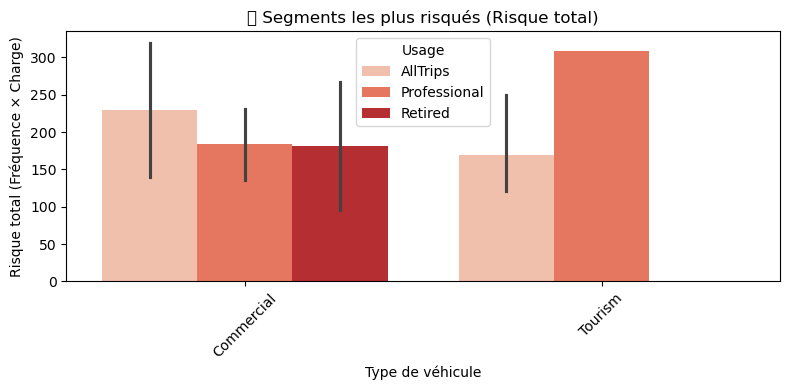

In [177]:
# Représentation graphique

# Barplot des 10 segments les plus risqués
top_risque = vehiculier_filtre.sort_values(by="risque_total", ascending=False).head(10)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=top_risque,
    y="risque_total",
    x="vh_type",
    hue="pol_usage",
    dodge=True,
    palette="Reds"
)
plt.title("🔝 Segments les plus risqués (Risque total)")
plt.xlabel("Type de véhicule")
plt.ylabel("Risque total (Fréquence × Charge)")
plt.xticks(rotation=45)
plt.legend(title="Usage")
plt.tight_layout()
plt.show() 

In [178]:
# interprétation:

# Commercial - AllTrips et Commercial - Retired: 
# Ces deux segments ont un risque modéré
# retired qui s'addresse aux retraités peut reflète des conducteurs âgés et donc moins réactifs aux volant entrainant des sinistres
# Sa peut également se traduire par le fait que ces véhicules peu utilisés, mais avec des sinistres coûteux quand ils arrivent.

# Le segment le plus risqué:
# les véhicules Tourisme utilisés à des fins professionnelles affichent un risque total plus élevé.
# L’usage Tous déplacements ou AllTrips sur véhicule Tourisme est moins risqué que l’usage professionnel.
# Ce qui implique les véhicules utilisés pour des fins professsionnelles ont une fréquence élevée de sinistres. 

## Effet combiné du carburant et de l'usage du véhicule sur la sinistralité

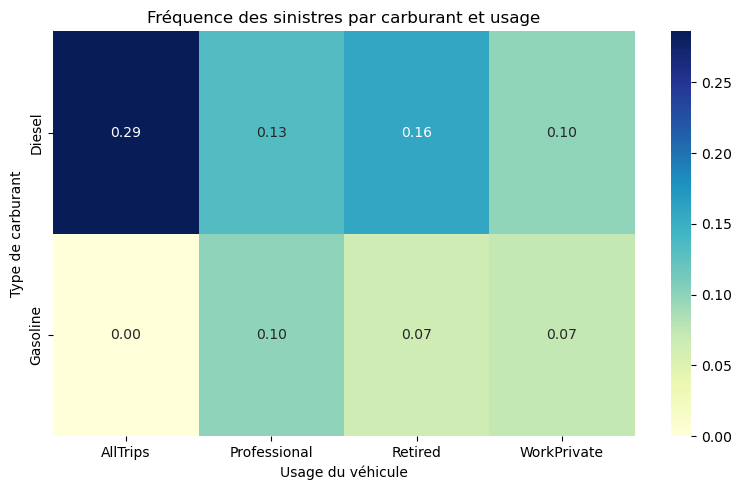

In [179]:
#  Heatmap : fréquence × usage et type de carburant
pivot_heatmap = vehiculier_filtre.pivot_table(
    index="vh_fuel", columns="pol_usage", values="freq_sinistre"
)

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_heatmap, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Fréquence des sinistres par carburant et usage")
plt.xlabel("Usage du véhicule")
plt.ylabel("Type de carburant")
plt.tight_layout()
plt.show()

In [180]:
# interprétation: 
#Chaque case représente la fréquence moyenne de sinistre pour un couple (vh_fuel, pol_usage)
#Plus la case est foncée plus la fréquence est élevée 
# Les véhicules à carburant essence (Gasoline) ou diesel en usage professionnel ont les fréquences de sinistres les plus élevées.
#En usage privé, les fréquences sont plus faibles. 

# Recommandation stratégique:
# Certains véhicules pros (SUV, Commercial)	Doivent être tarifés avec prudence
# L’usage et le carburant sont des facteurs clés	Ils doivent être intégrés dans la grille tarifaire

# Analyse spatiale sur la France (code INSEE): construction de zonier

**J'ai réappliqué le nettoyage de la base climatique dans cette section afin de rendre la base de données modélisable.**

In [181]:
# importation
base4 = pd.read_csv("DataClimatiques.csv",sep = ",", decimal = ",") 

C:\Users\cleme\AppData\Local\Temp\ipykernel_18972\818868361.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  base4 = pd.read_csv("DataClimatiques.csv",sep = ",", decimal = ",")


In [182]:
base4.head() 

,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMM,RR,QRR,NBRR,RR_ME,...,NEIGETOTAB,QNEIGETOTAB,NEIGETOTABDAT,NBJNEIGETOT1,NBJNEIGETOT10,NBJNEIGETOT30,NBJGREL,NBJORAG,NBJBROU,DEP
0,1014002,ARBENT,46.278167,5.669,534,202301,112.8,1.0,31.0,NaN,...,12.0,9.0,19.0,15.0,2.0,0.0,NaN,NaN,NaN,1
1,1014002,ARBENT,46.278167,5.669,534,202302,19.4,1.0,28.0,NaN,...,0.0,9.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,1
2,1014002,ARBENT,46.278167,5.669,534,202303,134.4,1.0,31.0,NaN,...,1.0,9.0,3.0,2.0,0.0,0.0,NaN,NaN,NaN,1
3,1014002,ARBENT,46.278167,5.669,534,202304,113.6,1.0,30.0,NaN,...,0.0,9.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,1
4,1014002,ARBENT,46.278167,5.669,534,202305,54.4,1.0,31.0,NaN,...,1.0,9.0,31.0,2.0,0.0,0.0,NaN,NaN,NaN,1


In [183]:
# on obtient le nombre de valeurs manquantes pour chaque variable
# somme par colonne
base4.isna().sum()
# Filtrer et afficher uniquement les colonnes avec des valeurs manquantes
valeurs_manquantes = base4.isna().sum()
# affichage des variables qui ont plus de 50% des donnnées manquantes( variables trop dégradées donc à supprimer)
valeurs_manquantes = valeurs_manquantes[valeurs_manquantes > (len(base4)/2)]
# Afficher le résultat
print(valeurs_manquantes)
# Identifier les colonnes ayant plus de 50% de valeurs manquantes
colonnes_a_supprimer = valeurs_manquantes.index

# Supprimer ces colonnes du DataFrame
base4_clean = base4.drop(columns=colonnes_a_supprimer)

# Afficher la nouvelle taille du DataFrame
print(f"Colonnes supprimées : {len(colonnes_a_supprimer)}")
print(f"Nouvelle taille du DataFrame : {base4_clean.shape}")
valeurs_manquantes = base4_clean.isna().sum()
valeurs_manquantes = valeurs_manquantes[valeurs_manquantes > 0]
# Remplissage des données manquantes pour les variables(entier et float) par la médiane
num_cols = base4_clean.select_dtypes(include=['float64', 'int64']).columns

for col in num_cols:
    base4_clean[col].fillna(base4_clean[col].median(), inplace=True)
# Remplissage des données manquantes pour les variables(objet) par le mode

cat_cols = base4_clean.select_dtypes(include=['object']).columns

for col in cat_cols:
    base4_clean[col].fillna(base4_clean[col].mode()[0], inplace=True)


RR_ME            27998
PMERM            25445
QPMERM           25445
PMERMINAB        25445
QPMERMINAB       25445
                 ...  
NBJNEIGETOT10    23605
NBJNEIGETOT30    23605
NBJGREL          27649
NBJORAG          26080
NBJBROU          25773
Length: 78, dtype: int64
Colonnes supprimées : 78
Nouvelle taille du DataFrame : (28162, 85)


C:\Users\cleme\AppData\Local\Temp\ipykernel_18972\2141905873.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base4_clean[col].fillna(base4_clean[col].median(), inplace=True)
C:\Users\cleme\AppData\Local\Temp\ipykernel_18972\2141905873.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

In [184]:
base4_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28162 entries, 0 to 28161
Data columns (total 85 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NUM_POSTE    28162 non-null  int64  
 1   NOM_USUEL    28162 non-null  object 
 2   LAT          28162 non-null  object 
 3   LON          28162 non-null  object 
 4   ALTI         28162 non-null  int64  
 5   AAAAMM       28162 non-null  int64  
 6   RR           28162 non-null  object 
 7   QRR          28162 non-null  float64
 8   NBRR         28162 non-null  float64
 9   RRAB         28162 non-null  object 
 10  QRRAB        28162 non-null  float64
 11  RRABDAT      28162 non-null  float64
 12  NBJRR1       28162 non-null  float64
 13  NBJRR5       28162 non-null  float64
 14  NBJRR10      28162 non-null  float64
 15  NBJRR30      28162 non-null  float64
 16  NBJRR50      28162 non-null  float64
 17  NBJRR100     28162 non-null  float64
 18  NBPMERM      28162 non-null  float64
 19  TX  

In [185]:
# Sauvegarde
base4_clean.to_csv('baseClimatique.csv', index=False)

In [186]:
BASE4 = base4_clean.copy()

In [188]:
# Base 4: Base Climatique: 
base_clim=BASE4.copy() 

In [189]:
base_clim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28162 entries, 0 to 28161
Data columns (total 85 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NUM_POSTE    28162 non-null  int64  
 1   NOM_USUEL    28162 non-null  object 
 2   LAT          28162 non-null  object 
 3   LON          28162 non-null  object 
 4   ALTI         28162 non-null  int64  
 5   AAAAMM       28162 non-null  int64  
 6   RR           28162 non-null  object 
 7   QRR          28162 non-null  float64
 8   NBRR         28162 non-null  float64
 9   RRAB         28162 non-null  object 
 10  QRRAB        28162 non-null  float64
 11  RRABDAT      28162 non-null  float64
 12  NBJRR1       28162 non-null  float64
 13  NBJRR5       28162 non-null  float64
 14  NBJRR10      28162 non-null  float64
 15  NBJRR30      28162 non-null  float64
 16  NBJRR50      28162 non-null  float64
 17  NBJRR100     28162 non-null  float64
 18  NBPMERM      28162 non-null  float64
 19  TX  

In [190]:
# Renommer la colonne dans la base climatique pour favoriser la jointure
base_clim = base_clim.rename(columns={"DEP": "DEPT"})

## Sélectionner les variables pertinentes pour la base climatique

In [191]:
# Liste initiale de variables souhaitées
vars_clim = [
    "RR", "NBJRR10", "NBJRR30",              # Précipitations
    "INST", "GLOT",                          # Ensoleillement
    "TX", "TN", "TM",                        # Températures
    "NBJTX30", "NBJTN5", "TAMPLIM",          # Extrêmes thermiques
    "FFM", "NBJFF16",                        # Vent
    "NBJBROU", "NBJGELEE", "NBJNEIGETOT10",  # Hiver / brouillard
    "DEPT"
]

# Garder uniquement les colonnes présentes
vars_existantes = [col for col in vars_clim if col in base_clim.columns]

# Afficher celles qui existent
print("Colonnes conservées :", vars_existantes)

# Filtrage
clim_filtered = base_clim[vars_existantes].copy()

# Renommage du code département
if "DEP" in clim_filtered.columns:
    clim_filtered.rename(columns={"DEP": "DEPT"}, inplace=True)

# Nettoyage du code département
clim_filtered["DEPT"] = clim_filtered["DEPT"].astype(str).str.zfill(2)

# Affichage de contrôle
clim_filtered.head()

Colonnes conservées : ['RR', 'NBJRR10', 'NBJRR30', 'TX', 'TN', 'TM', 'NBJTX30', 'NBJTN5', 'TAMPLIM', 'NBJGELEE', 'DEPT']


,RR,NBJRR10,NBJRR30,TX,TN,TM,NBJTX30,NBJTN5,TAMPLIM,NBJGELEE,DEPT
0,112.8,4.0,0.0,6.4,-1.2,2.6,0.0,10.0,7.6,15.0,01
1,19.4,0.0,0.0,10.7,-3.7,3.5,0.0,13.0,14.4,21.0,01
2,134.4,6.0,0.0,13.3,1.6,7.4,0.0,4.0,11.8,12.0,01
3,113.6,5.0,0.0,14.6,2.4,8.5,0.0,3.0,12.2,10.0,01
4,54.4,1.0,0.0,20.6,7,13.8,0.0,0.0,13.5,0.0,01


In [192]:
clim_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28162 entries, 0 to 28161
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RR        28162 non-null  object 
 1   NBJRR10   28162 non-null  float64
 2   NBJRR30   28162 non-null  float64
 3   TX        28162 non-null  object 
 4   TN        28162 non-null  object 
 5   TM        28162 non-null  object 
 6   NBJTX30   28162 non-null  float64
 7   NBJTN5    28162 non-null  float64
 8   TAMPLIM   28162 non-null  object 
 9   NBJGELEE  28162 non-null  float64
 10  DEPT      28162 non-null  object 
dtypes: float64(5), object(6)
memory usage: 2.4+ MB


In [193]:
# Liste des colonnes à convertir en float
colonnes_a_convertir = ['RR', 'TX', 'TN', 'TM', 'TAMPLIM']

# Conversion forcée, en gérant les erreurs
for col in colonnes_a_convertir:
    clim_filtered[col] = pd.to_numeric(clim_filtered[col])  # transforme les erreurs en NaN

# Vérification
print(clim_filtered.dtypes)

RR          float64
NBJRR10     float64
NBJRR30     float64
TX          float64
TN          float64
TM          float64
NBJTX30     float64
NBJTN5      float64
TAMPLIM     float64
NBJGELEE    float64
DEPT         object
dtype: object


In [194]:
# Filtrer les colonnes présentes
vars_existantes = [col for col in vars_clim if col in base_clim.columns]
clim_filtered = base_clim[vars_existantes].copy()

# Renommer la colonne DEP en DEPT
if "DEP" in clim_filtered.columns:
    clim_filtered.rename(columns={"DEP": "DEPT"}, inplace=True)

# Nettoyage du code département
if "DEPT" in clim_filtered.columns:
    clim_filtered["DEPT"] = clim_filtered["DEPT"].astype(str).str.zfill(2)

# Agrégation par département
colonnes_numeriques = clim_filtered.select_dtypes(include=["number"]).columns.tolist()
zonier = clim_filtered.groupby("DEPT")[colonnes_numeriques].mean().reset_index()
#zonier = clim_filtered.groupby("DEPT").mean().reset_index()

In [195]:
zonier.head()

,DEPT,NBJRR10,NBJRR30,NBJTX30,NBJTN5,NBJGELEE
0,01,3.612745,0.651961,3.063725,1.156863,5.490196
1,02,1.987179,0.089744,1.288462,0.250000,3.333333
2,03,2.041667,0.117424,3.121212,0.628788,4.060606
3,04,2.195876,0.415808,2.893471,2.790378,8.701031
4,05,2.731148,0.577049,1.286885,3.826230,9.747541


In [196]:
from sklearn.preprocessing import StandardScaler

# Standardisation des variables climatiques
scaler = StandardScaler()
zonier_scaled = scaler.fit_transform(zonier.drop(columns=["DEPT"]))

# Conversion en DataFrame pour visualisation
zonier_scaled_df = pd.DataFrame(zonier_scaled, columns=zonier.columns.drop("DEPT"))
zonier_scaled_df["DEPT"] = zonier["DEPT"].values

print(zonier_scaled_df)

      NBJRR10   NBJRR30   NBJTX30    NBJTN5  NBJGELEE DEPT
0    0.864140  0.741058  0.026937  0.657660  0.992755   01
1   -0.658786 -0.576060 -0.560097 -0.428688 -0.061060   02
2   -0.607739 -0.511212  0.045946  0.025069  0.294276   03
3   -0.463267  0.187817 -0.029362  2.614478  2.561527   04
4    0.038207  0.565561 -0.560618  3.855343  3.072838   05
..        ...       ...       ...       ...       ...  ...
100 -0.213604  0.145746  1.509897  3.393702  0.816295  984
101  0.660924  1.523879  3.787947 -0.728168 -1.689683  985
102  4.386547  5.782501  1.172949 -0.728168 -1.689683  986
103  1.846949  2.654968  0.743684 -0.728168 -1.689683  987
104  0.059978  1.459537  1.132145 -0.728168 -1.689683  988

[105 rows x 6 columns]


## Clustering des départements (zonier climatique)
* l'objectif est de créer des zones climatiques homogènes pour comprendre leur effet sur la sinistralité.

In [197]:
from sklearn.cluster import KMeans

# Retirer la colonne "DEPT" pour effectuer le clustering
X = zonier_scaled_df.drop("DEPT", axis=1)

# Appliquer le clustering KMeans avec 4 clusters
kmeans = KMeans(n_clusters=4, random_state=0)
zonier_scaled_df["zone_climatique"] = kmeans.fit_predict(X)

# Afficher un aperçu du zonier avec les clusters
zonier_scaled_df.head()

C:\Users\cleme\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,NBJRR10,NBJRR30,NBJTX30,NBJTN5,NBJGELEE,DEPT,zone_climatique
0,0.864140,0.741058,0.026937,0.657660,0.992755,01,2
1,-0.658786,-0.576060,-0.560097,-0.428688,-0.061060,02,0
2,-0.607739,-0.511212,0.045946,0.025069,0.294276,03,0
3,-0.463267,0.187817,-0.029362,2.614478,2.561527,04,2
4,0.038207,0.565561,-0.560618,3.855343,3.072838,05,2


In [198]:
## La base Climatique a été aggrégée en 4 zones climatiques de 0 à 3. Caractéristiques de chaque zone:

# Zone 0: Précipitations moyennes à fortes; climat océanique humide typique de l'ouest et du nord-ouest.
# La température est modérée, et le Gel et le brouillard fréquents dans la zone 0: il s'agit de la Bretagne et de la Normandie

#Zone 1:  Ensoleillement important ,Températures élevées, Peu de gel ou neige. On a un climat méditerranéen chaud: Climat méditerranéen chaud 
# Il s'agit du Sud-Est de la France: PACA, Languedoc.

#Zone 2:Les Précipitations sont modérées, Températures équilibrées Vent présent mais pas extrême. 
# Il s'agit d'un climat continental tempéré: C'est le centre et l'Est: Bourgogne, Centre-Val de Loire. 

#Zone 3: Températures basses, ensoleillement faible nombreux jours de gel et de neige.
#climat froid, Massif Central, Alpes, Pyrénées et zones d’altitude.

In [199]:
# sauvegarde du zonier
zonier_scaled_df.to_csv("zonier_scaled_df.csv", index=False)

In [200]:
zonier_scaled_df.columns

Index(['NBJRR10', 'NBJRR30', 'NBJTX30', 'NBJTN5', 'NBJGELEE', 'DEPT',
       'zone_climatique'],
      dtype='object')

In [201]:
# Base des assurés sinistrés ou non sinistrés
ass.head()

,id_client_x,id_vehicle_x,id_policy,id_year_x,pol_bonus,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,...,vh_speed,vh_type,vh_value,vh_weight,id_claim,claim_nb,claim_amount,sinistre,cyl_class,speed_class
0,A00072644,V01,A00072644-V01,Year 0,0.50,4,8.0,4.0,Monthly,No,...,192.0,Tourism,18000.0,1320.0,CL01,1.0,1860.92,1,standard,rapide
1,A00036953,V01,A00036953-V01,Year 0,0.50,4,11.0,1.0,Yearly,No,...,216.0,Tourism,32000.0,1399.0,0,0.0,0.00,0,standard,rapide
2,A00079066,V01,A00079066-V01,Year 0,0.50,4,7.0,1.0,Yearly,No,...,185.0,Tourism,20800.0,1320.0,0,0.0,0.00,0,moyenne,rapide
3,A00018024,V01,A00018024-V01,Year 0,0.64,3,5.0,1.0,Yearly,No,...,190.0,Tourism,12517.0,860.0,0,0.0,0.00,0,moyenne,rapide
4,A00019276,V01,A00019276-V01,Year 0,0.72,1,1.0,1.0,Monthly,No,...,143.0,Tourism,9742.0,820.0,0,0.0,0.00,0,petite,élevée


In [202]:
#  Extraire le code département depuis pol_insee_code (chaîne)
ass["code_dept"] = ass["pol_insee_code"].astype(str).str[:2].str.zfill(2)

#  S'assurer que le zonier est aussi en string et zfill(2)
zonier_scaled_df["DEPT"] = zonier_scaled_df["DEPT"].astype(str).str.zfill(2)

# Jointure propre
ass_with_zone = pd.merge(
    ass, zonier_scaled_df[["DEPT", "zone_climatique"]],
    left_on="code_dept", right_on="DEPT", how="left"
)

# Vérification
print(ass_with_zone[["pol_insee_code", "code_dept", "zone_climatique"]].head())


  pol_insee_code code_dept  zone_climatique
0           7181        71              0.0
1          67419        67              0.0
2          69081        69              0.0
3          69270        69              0.0
4          19151        19              2.0


In [203]:
ass_with_zone.head()

,id_client_x,id_vehicle_x,id_policy,id_year_x,pol_bonus,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,...,vh_weight,id_claim,claim_nb,claim_amount,sinistre,cyl_class,speed_class,code_dept,DEPT,zone_climatique
0,A00072644,V01,A00072644-V01,Year 0,0.50,4,8.0,4.0,Monthly,No,...,1320.0,CL01,1.0,1860.92,1,standard,rapide,71,71,0.0
1,A00036953,V01,A00036953-V01,Year 0,0.50,4,11.0,1.0,Yearly,No,...,1399.0,0,0.0,0.00,0,standard,rapide,67,67,0.0
2,A00079066,V01,A00079066-V01,Year 0,0.50,4,7.0,1.0,Yearly,No,...,1320.0,0,0.0,0.00,0,moyenne,rapide,69,69,0.0
3,A00018024,V01,A00018024-V01,Year 0,0.64,3,5.0,1.0,Yearly,No,...,860.0,0,0.0,0.00,0,moyenne,rapide,69,69,0.0
4,A00019276,V01,A00019276-V01,Year 0,0.72,1,1.0,1.0,Monthly,No,...,820.0,0,0.0,0.00,0,petite,élevée,19,19,2.0


In [204]:
# Sauvegarde
ass_with_zone.to_csv("ass_with_zone.csv", index=False)

# Régression logistique pour analyser l'effet de la zone climatique sur la probabilité de sinistre (claim_amount > 0) 

In [205]:
ass["code_dept"] = ass["pol_insee_code"].str[:2]
zonier_scaled_df["DEPT"] = zonier_scaled_df["DEPT"].astype(str).str.zfill(2)

# Jointure
ass_with_zone = pd.merge(ass, zonier_scaled_df[["DEPT", "zone_climatique"]], left_on="code_dept", right_on="DEPT", how="left")

# Création de la variable cible (sinistre oui/non)
ass_with_zone["sinistre"] = (ass_with_zone["claim_amount"] > 0).astype(int)

# Encodage de la variable zone_climatique
ass_with_zone["zone_climatique"] = ass_with_zone["zone_climatique"].astype("category")

# Régression logistique sur l'effet de la zone climatique
import statsmodels.api as sm
import patsy

# Modélisation de la probabilité de sinistre en fonction de chaque zone climatique
y, X = patsy.dmatrices("sinistre ~ C(zone_climatique)", data=ass_with_zone, return_type="dataframe")

# Modèle logistique
logit_model = sm.Logit(y, X).fit(disp=False)

# Résumé du modèle
logit_summary = logit_model.summary()
logit_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               sinistre   No. Observations:                99578
Model:                          Logit   Df Residuals:                    99575
Method:                           MLE   Df Model:                            2
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:               0.0001095
Time:                        21:53:03   Log-Likelihood:                -34559.
converged:                       True   LL-Null:                       -34563.
Covariance Type:            nonrobust   LLR p-value:                   0.02270
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -2.0592      0.014   -142.215      0.000      -2.088      -2.031
C(zone_climatique)[T.2.0]    -0.0490      0.034     -1.422      0.155      -0.117       0.019
C(zone_climatique)[T.3.0]    -0.0572      0.021     -2.662      0.008      -0.099      -0.015
=============================================================================================
"""

In [206]:
# interprétation:

#Intercept (-2.0592) : #Ce coefficient correspond à la zone climatique de référence, ici la zone 0 (climat océanique humide,Bretagne et Normandie).
#Cela signifie qu'en zone 0, la probabilité de sinistre est faible, 
#ce qui reflète un environnement climatique où l'humidité est forte mais avec des températures relativement modérées.

#Zone 2 (Climat continental tempéré - Bourgogne, Centre-Val de Loire) :Le coefficient associé à la zone 2 est négatif (-0.0490) mais non significatif (p=0.155).
#Il n'y a pas de différence significative de risque de sinistre entre les assurés vivant en zone 2 et ceux vivant en zone 0.
#Le climat plus équilibré (températures tempérées, précipitations modérées) n’a pas d’impact clair sur la probabilité de sinistre. 

# Zone 3 (Climat froid, régions montagneuses - Massif Central, Alpes, Pyrénées) :
#Le coefficient est négatif et significatif (-0.0572 ; p=0.008) : 
#Les assurés vivant dans ces zones à climat froid et neigeux présentent un risque de sinistre légèrement inférieur à ceux vivant dans la zone 0 (océanique humide).
#Cela peut s’expliquer par des comportements de prudence plus marqués en milieu montagneux (conduite plus adaptée aux conditions hivernales difficiles).

# Pseudo R² = 0.0001 : Ce très faible score indique que, même si l’effet est significatif,
#la zone climatique seule n’explique qu’une infime partie de la variabilité des sinistres.

# LLR p-value = 0.0227 : le modèle est globalement significatif, donc il existe une relation entre climat et sinistralité, 
#mais cet effet est très modéré.


## Création d'un GLM pout tester l'effet des différentes zones sur le montant des sinistres

In [207]:
# Suppression des lignes avec claim_amount manquant ou nul
ass_glm = ass_with_zone[ass_with_zone["claim_amount"] > 0].copy()

# Construction de la formule avec quelques variables explicatives
formula = "claim_amount ~ C(zone_climatique)"

# Création des matrices pour le modèle
y, X = patsy.dmatrices(formula, data=ass_glm, return_type="dataframe")

# Modèle GLM avec distribution Gamma (adapté aux montants positifs)
glm_model = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log()))
glm_result = glm_model.fit()

glm_result.summary()

C:\Users\cleme\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           claim_amount   No. Observations:                10981
Model:                            GLM   Df Residuals:                    10978
Model Family:                   Gamma   Df Model:                            2
Link Function:                    log   Scale:                          6.0576
Method:                          IRLS   Log-Likelihood:                -94214.
Date:                Tue, 29 Apr 2025   Deviance:                       13656.
Time:                        21:53:03   Pearson chi2:                 6.65e+04
No. Iterations:                     8   Pseudo R-squ. (CS):          0.0004999
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     6.9639      0.034    207.497      0.000       6.898       7.030
C(zone_climatique)[T.2.0]    -0.0655      0.080     -0.818      0.413      -0.222       0.091
C(zone_climatique)[T.3.0]    -0.1167      0.050     -2.341      0.019      -0.214      -0.019
=============================================================================================
"""

In [208]:
# interprétation:
#la zone 2 climat continental tempéré n'a pas d'effet significatif sur le montant des sinistres par rapport à la zone de référence zone 0, climat océanique humide, 
#avec une p-value de 0,413.

#la zone 3 climat froid d'altitude : Massif Central, Alpes, Pyrénées présente une réduction significative du coût des sinistres par rapport à la zone de référence (coefficient de -0,1167, p-value = 0,019). 
#Cela signifie que, toutes choses égales par ailleurs, les sinistres sont en moyenne moins coûteux dans ces régions froides et montagneuses.

# Arbre de décision pour prédire les sinistres
* Objectif  : L’arbre vise à déterminer si un assuré va déclarer un sinistre (classe 1) ou non (classe 0), à partir de différentes caractéristiques du contrat.

* Utilisation d'un arbre de décision avec class_weight balanced pour compenser le déséquilibre entre sinistrés (classe 1) et non-sinistrés (classe 0).

In [209]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import plot_tree

In [210]:
# Colonnes à encoder
cat_cols = [
    "pol_pay_freq", "pol_payd", "pol_usage",
    "drv_drv2", "drv_sex1", "vh_fuel", "vh_type",
    "cyl_class", "speed_class"
]

# Encodage OneHot (drop_first=True pour éviter la colinéarité)
ass_encoded = pd.get_dummies(ass_with_zone, columns=cat_cols, drop_first=True)

[[26232   483]
 [    0  3272]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     26715
           1       0.87      1.00      0.93      3272

    accuracy                           0.98     29987
   macro avg       0.94      0.99      0.96     29987
weighted avg       0.99      0.98      0.98     29987



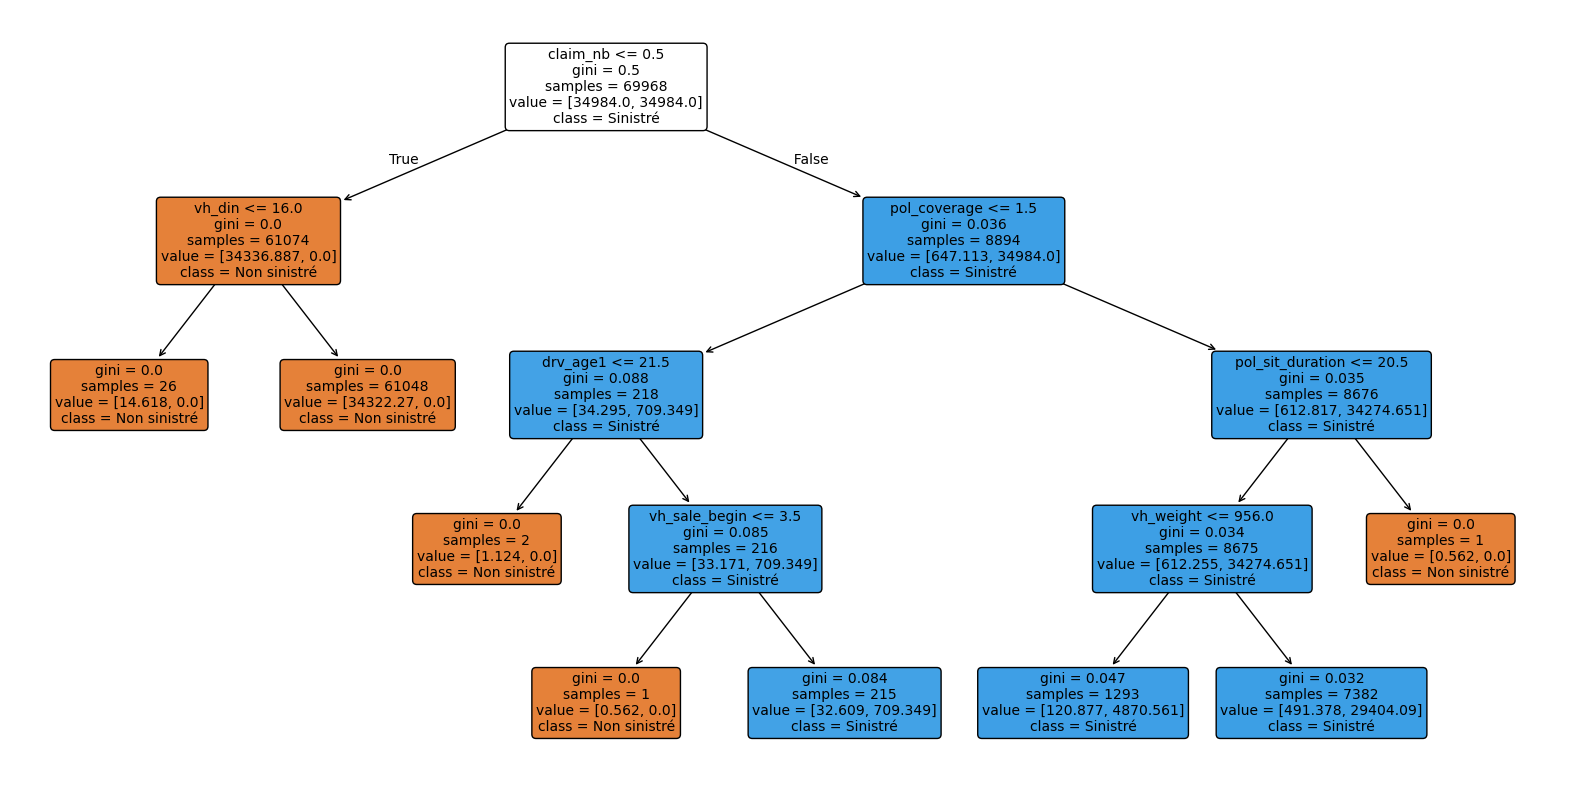

In [211]:
# Étape 1 : Retirer les colonnes inutiles
cols_to_drop = ["sinistre", "claim_amount", "id_policy", "pol_insee_code"]
X = ass_encoded.drop(columns=[col for col in cols_to_drop if col in ass_encoded.columns])
y = ass_encoded["sinistre"]

# Étape 2 : Conserver uniquement les variables numériques
X = X.select_dtypes(include=["number"])

# Étape 3 : Split train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Étape 4 : Arbre de décision pondéré
clf_balanced = DecisionTreeClassifier(class_weight="balanced", max_depth=4, random_state=0)
clf_balanced.fit(X_train, y_train)

# Étape 5 : Évaluation du modèle
y_pred = clf_balanced.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Visualisation
plt.figure(figsize=(20, 10))  # adapte la taille selon la profondeur
plot_tree(clf_balanced, 
          feature_names=X.columns,
          class_names=["Non sinistré", "Sinistré"],
          filled=True,
          rounded=True,
          fontsize=10)
plt.show()

In [212]:
                                                                   # Interprétation:

# la racine de l'arbre claim_nb sépare les individus en fonction du nombre de sinistre;
# C’est la variable la plus discriminante. Elle sépare les individus en fonction du nombre de sinistres antérieurs :
# S’il y a 0 sinistre antérieur → l’assuré est classé non sinistré avec une forte probabilité (gini ≈ 0, 34k observations).
# S’il y a ≥1 sinistre antérieur → l’assuré est beaucoup plus à risque d’avoir un nouveau sinistre.

# Les assurés avec claim_nb <= 0.5 sont presque tous classés non sinistrés.
#C’est un groupe très homogène : pas de sinistres passés = très faible probabilité de sinistre futur.

# Branche droite : antécédents > 0
#Les assurés ayant des sinistres passés sont beaucoup plus à risque.

#Parmi eux, la segmentation se fait sur :

#pol_sit_duration : durée de souscription.
#Moins la durée est longue, plus le risque est fort.

#pol_coverage : niveau de couverture.
#Couverture faible (<=1.5) = sinistralité plus forte.

#vh_value : valeur du véhicule.
#Véhicules de valeur plus élevée (ex. > 67000) ont une sinistralité plus marquée.

#vh_weight : poids du véhicule.
#Véhicules plus lourds ont légèrement moins de sinistres.


In [213]:
                                                    # Performance du modèle: 
# Très bonne précision (=98%).
# Excellent recall pour les sinistres (classe 1), ce qui signifie que le modèle détecte bien les assurés sinistrés.
#Les faux positifs sont faibles : très peu de personnes prédites comme sinistrées alors qu’elles ne le sont pas.

                                                            # Conclusion :
#Le nombre de sinistres passés est de loin la variable la plus importante dans la prédiction.
#Le modèle met en évidence des profils à risque selon :
#la durée de souscription (clients récents = + de risque),
#la couverture choisie (plus faible = plus risqué ?),
#la valeur du véhicule (plus élevé = plus risqué),
#et le poids du véhicule (véhicules plus légers = + sinistralité ?).

# Analyse plus fine par segment  : exploration d'un modèle plus complexe  : XGBoost pour prédire les sinistres. 

In [214]:
!pip install xgboost

In [215]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Préparation des données
X = ass_encoded.drop(columns=["sinistre", "claim_amount", "id_policy", "pol_insee_code"], errors="ignore")
y = ass_encoded["sinistre"]

# Ne garder que les variables numériques
X = X.select_dtypes(include=["number"])

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modèle XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=0)
xgb_model.fit(X_train, y_train)

# Prédictions
y_pred = xgb_model.predict(X_test)
# Calculs d'évaluation
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

conf_matrix, class_report, accuracy
# évaluation 

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

C:\Users\cleme\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:53:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[26236   479]
 [   33  3239]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     26715
           1       0.87      0.99      0.93      3272

    accuracy                           0.98     29987
   macro avg       0.93      0.99      0.96     29987
weighted avg       0.98      0.98      0.98     29987



In [216]:
# Matrice de confusion
#Vrais négatifs (VN) : 26 236 assurés non sinistrés ont été correctement classés comme tels.
#Faux positifs (FP) : 479 assurés non sinistrés ont été incorrectement prédits comme sinistrés. Cela reste un volume faible, indiquant un faible taux d’alerte injustifiée.
#Faux négatifs (FN) : 33 assurés sinistrés ont été incorrectement prédits comme non sinistrés. Ce nombre est très limité, ce qui est crucial car les faux négatifs sont coûteux pour un assureur (un sinistre non anticipé).
#Vrais positifs (VP) : 3239 assurés sinistrés ont été correctement identifiés comme sinistrés.
                                     # Accuracy
#98 % de bonne prédiction globale → excellente performance du modèle.

                                     #Conclusion
#le modèle est très efficace, surtout pour détecter les sinistres (classe minoritaire), ce qui est crucial en assurance.
#La légère baisse de précision sur la classe 1 est normale vu le déséquilibre des classes.
#Très bon point de départ pour la phase machine learning avancée.
# On a un nombre assez significatif d'assurés sinistré qui ont été prédits comme non sinistrés d'où la nécessité 
#d'optimiser les hyperparamètres pour avoir un modèle robuste

## Optimisation des hyperparamètres vu que la cible est minoritaire afin d'avoir un modèle robuste

In [217]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Étape 1 : Séparer features et target
X = ass_encoded.drop(columns=["sinistre", "claim_amount", "id_policy", "pol_insee_code"])
X = X.select_dtypes(include=["number"])  # On garde que les colonnes numériques
y = ass_encoded["sinistre"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Étape 2 : Définir la grille d'hyperparamètres
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 4, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [1, 5, 10]  # pour équilibrer les classes
}

# Étape 3 : Configuration du GridSearch
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=0)
grid_search = GridSearchCV(xgb, param_grid, scoring="f1", cv=3, verbose=1, n_jobs=-1)

# Étape 4 : Lancement de la recherche
grid_search.fit(X_train, y_train)

# Étape 5 : Évaluation du meilleur modèle
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Meilleurs paramètres trouvés :", grid_search.best_params_)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Meilleurs paramètres trouvés : {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 5}
[[26231   484]
 [    1  3271]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     26715
           1       0.87      1.00      0.93      3272

    accuracy                           0.98     29987
   macro avg       0.94      0.99      0.96     29987
weighted avg       0.99      0.98      0.98     29987



C:\Users\cleme\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:53:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [218]:
# Interprétation
                                      # Paramètres optimaux
#Ces paramètres signifient :
#Vrais négatifs (TN) : 26 231 assurés sans sinistre correctement prédits.

#Faux positifs (FP) : 484 assurés prédits comme sinistrés alors qu'ils ne l'étaient pas (légèrement plus que souhaité, mais restant faible).
#Faux négatifs (FN) : 1 seul assuré sinistré non détecté — ce chiffre extrêmement faible est très satisfaisant.
#Vrais positifs (TP) : 3 271 assurés sinistrés correctement prédits.

#Accuracy (précision globale) : 98 %, ce qui montre un excellent taux de bonne prédiction sur l'ensemble des assurés.

                                    #Précision (precision) :

#Classe 0 (non sinistré) : 100 % → quasiment aucun assuré sans sinistre n'est confondu.
#Classe 1 (sinistré) : 87 % → lorsqu'un sinistre est prédit, il y a 87 % de chances que ce soit correct.
#Recall (rappel) :
#Classe 0 : 98 % → la plupart des non-sinistrés sont correctement identifiés.
#Classe 1 : 100 % → quasi tous les assurés réellement sinistrés sont détectés.
#F1-score : très élevé (0.99 pour les non-sinistrés, 0.93 pour les sinistrés), combinant précision et rappel.

# Conclusion
#Le modèle XGBoost optimisé est :
#Précis, fiable, et équilibré
#Robuste face au déséquilibre
#Performant sans surcomplexité